<a href="https://colab.research.google.com/github/edoofra/PathMNIST_classification_explainability/blob/main/PathMNIST_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto Image Data Analysis aa. 2022-2023 - Fratus Edoardo
Per questo progetto legato all'utilizzo di reti convoluzionali e tecniche di machine learning per l'analisi di dati sotto forma di immagini è stato utilizzato il dataset PathMNIST, facente parte di MedMNIST: https://medmnist.com

*The PathMNIST is based on a prior study16, 17 for predicting survival from colorectal cancer histology slides, providing a dataset
(NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and
a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types
of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split
NCT-CRC-HE-100K into training and validation set with a ratio of 9 : 1. The CRC-VAL-HE-7K is treated as the test set.*

In [ ]:
# IMPORTS
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Funzioni di utilità e import del dataset

### Import dei dataset

In questa prima sezione del notebook si trovano le definizioni delle funzioni di utility per l'utilizzo del dataset e l'importazione dello stesso nel progetto.

In [ ]:
!pip install medmnist


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=a692160f755ce5dd276dfcf1e52f3168194775ca55d13e259bf7c35409892fc9
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
import random

def shuffle_iterator(iterator):
    # iterator should have limited size
    index = list(iterator)
    total_size = len(index)
    i = 0
    random.shuffle(index)
    while True:
        yield index[i]
        i += 1
        if i >= total_size:
            i = 0
            random.shuffle(index)

def get_loader(dataset, batch_size):
    total_size = len(dataset)
    print('Size', total_size)
    index_generator = shuffle_iterator(range(total_size))
    while True:
        data = []
        for _ in range(batch_size):
            idx = next(index_generator)
            data.append(dataset[idx])
        yield dataset._collate_fn(data)

In [ ]:
import os
from collections import Sequence
from PIL import Image
from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT

class MedMNIST(Sequence):

    flag = ...

    def __init__(self,
                 split,
                 transform=None,
                 target_transform=None,
                 download=False,
                 as_rgb=False,
                 root=DEFAULT_ROOT):
        ''' dataset
        :param split: 'train', 'val' or 'test', select subset
        :param transform: data transformation
        :param target_transform: target transformation
        '''

        self.info = INFO[self.flag]

        if root is not None and os.path.exists(root):
            self.root = root
        else:
            raise RuntimeError("Failed to setup the default `root` directory. " +
                               "Please specify and create the `root` directory manually.")

        if download:
            self.download()

        if not os.path.exists(
                os.path.join(self.root, "{}.npz".format(self.flag))):
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        npz_file = np.load(os.path.join(self.root, "{}.npz".format(self.flag)))

        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.as_rgb = as_rgb

        if self.split == 'train':
            self.imgs = npz_file['train_images']
            self.labels = npz_file['train_labels']
        elif self.split == 'val':
            self.imgs = npz_file['val_images']
            self.labels = npz_file['val_labels']
        elif self.split == 'test':
            self.imgs = npz_file['test_images']
            self.labels = npz_file['test_labels']
        else:
            raise ValueError

    def __len__(self):
        return self.imgs.shape[0]

    def __repr__(self):
        '''Adapted from torchvision.ss'''
        _repr_indent = 4
        head = f"Dataset {self.__class__.__name__} ({self.flag})"
        body = [f"Number of datapoints: {self.__len__()}"]
        body.append(f"Root location: {self.root}")
        body.append(f"Split: {self.split}")
        body.append(f"Task: {self.info['task']}")
        body.append(f"Number of channels: {self.info['n_channels']}")
        body.append(f"Meaning of labels: {self.info['label']}")
        body.append(f"Number of samples: {self.info['n_samples']}")
        body.append(f"Description: {self.info['description']}")
        body.append(f"License: {self.info['license']}")

        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)

    def download(self):
        try:
            from torchvision.datasets.utils import download_url
            download_url(url=self.info["url"],
                         root=self.root,
                         filename="{}.npz".format(self.flag),
                         md5=self.info["MD5"])
        except:
            raise RuntimeError('Something went wrong when downloading! ' +
                               'Go to the homepage to download manually. ' +
                               HOMEPAGE)

    @staticmethod
    def _collate_fn(data):
        xs = []
        ys = []
        for x, y in data:
            xs.append(np.array(x))
            ys.append(y)
        return np.array(xs), np.array(ys)


<ipython-input-6-9860482f1fee>:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


In [ ]:
class MedMNIST2D(MedMNIST):

    def __getitem__(self, index):
        '''
        return: (without transform/target_transofrm)
            img: PIL.Image
            target: np.array of `L` (L=1 for single-label)
        '''
        img, target = self.imgs[index], self.labels[index].astype(int)
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def save(self, folder, postfix="png", write_csv=True):

        from medmnist.utils import save2d

        save2d(imgs=self.imgs,
               labels=self.labels,
               img_folder=os.path.join(folder, self.flag),
               split=self.split,
               postfix=postfix,
               csv_path=os.path.join(folder, f"{self.flag}.csv") if write_csv else None)

    def montage(self, length=20, replace=False, save_folder=None):
        from medmnist.utils import montage2d

        n_sel = length * length
        sel = np.random.choice(self.__len__(), size=n_sel, replace=replace)

        montage_img = montage2d(imgs=self.imgs,
                                n_channels=self.info['n_channels'],
                                sel=sel)

        if save_folder is not None:
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            montage_img.save(os.path.join(save_folder,
                                          f"{self.flag}_{self.split}_montage.jpg"))

        return montage_img

In [ ]:
# definizione della classe specifica per il dataset scelto
class PathMNIST(MedMNIST2D):
    flag = "pathmnist"

In [ ]:
# download dei dati splittati in train, validation e test
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = PathMNIST(split='train', download=download)
validation_dataset = PathMNIST(split='val', download=download)
test_dataset = PathMNIST(split='test', download=download)

  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
train_dataset.save("train")

100%|██████████| 89996/89996 [00:30<00:00, 2974.91it/s]


In [ ]:
validation_dataset.save("validation")

100%|██████████| 10004/10004 [00:02<00:00, 3430.71it/s]


In [ ]:
test_dataset.save("test")

100%|██████████| 7180/7180 [00:02<00:00, 3519.84it/s]


### Analisi esplorativa

In [ ]:
train_dataset

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

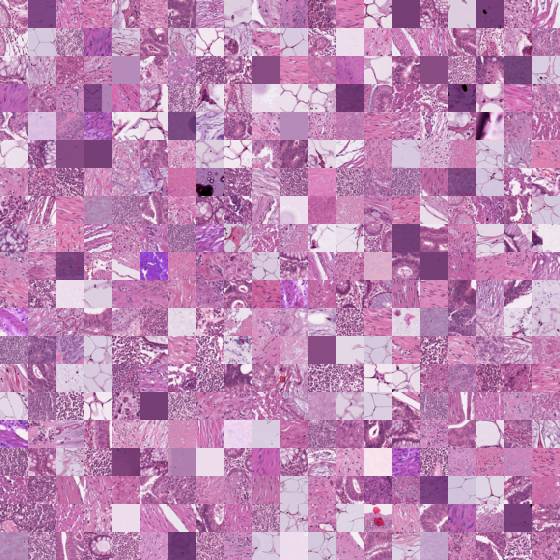

In [ ]:
train_dataset.montage()

In [ ]:
x, y = train_dataset[0]

print(np.array(x).shape, y.shape)

(28, 28, 3) (1,)


In [ ]:
x

In [ ]:
y[0]

0

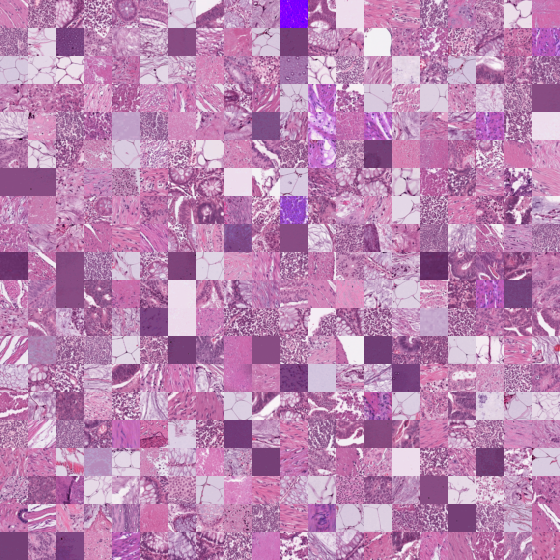

In [ ]:
validation_dataset.montage()

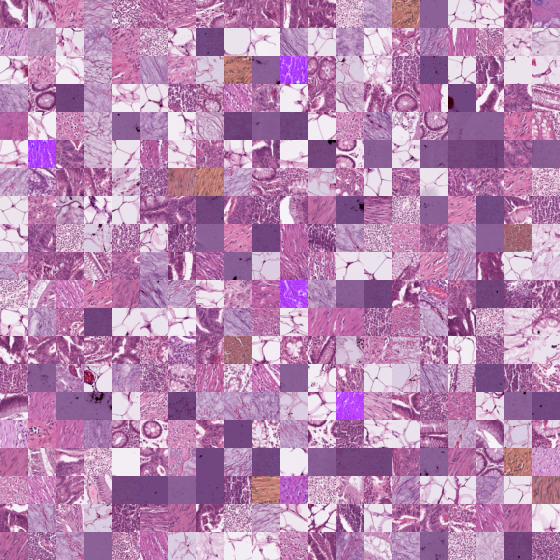

In [ ]:
test_dataset.montage()

In [ ]:
!pip install git+https://github.com/keras-team/keras-preprocessing.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-4dc42nft
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-4dc42nft
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd

traindf=pd.read_csv('train/pathmnist.csv',dtype=str)
datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory="train/pathmnist",
  x_col="train0_0.png",
  y_col="0",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(64,64))

valdf = pd.read_csv('validation/pathmnist.csv',dtype=str)
val_generator=datagen.flow_from_dataframe(
  dataframe=valdf,
  directory="validation/pathmnist",
  x_col="val0_5.png",
  y_col="5",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(64,64))

Found 89995 validated image filenames belonging to 9 classes.
Found 10003 validated image filenames belonging to 9 classes.


In [ ]:
traindf = traindf[['train0_0.png','0']]
traindf

,train0_0.png,0
0,train1_4.png,4
1,train2_7.png,7
2,train3_5.png,5
3,train4_5.png,5
4,train5_8.png,8
...,...,...
89990,train89991_0.png,0
89991,train89992_6.png,6
89992,train89993_2.png,2
89993,train89994_0.png,0


In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89995 entries, 0 to 89994
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   train0_0.png  89995 non-null  object
 1   0             89995 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [ ]:
traindf.describe()

,train0_0.png,0
count,89995,89995
unique,89995,9
top,train1_4.png,8
freq,1,12885


In [ ]:
traindf['0']=traindf['0'].astype('int64')

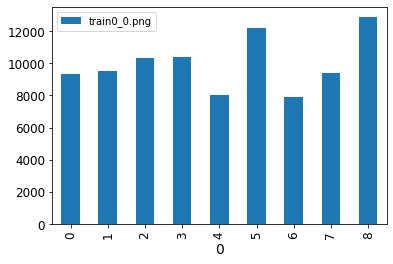

In [ ]:
traindf.groupby(['0']).count().plot(kind='bar')

Come è possibile notare dal grafico sopra riportato, abbiamo un dataset sbilanciato per quanto riguarda le classi nel trainset. Essendo questo sbilanciamento non eccessivo, ho deciso inizialmente di trascurarlo, provando comunque ad addestrare i modelli ed eventualmente correggendo tale sbilanciamento in futuro se ciò dovesse rendersi necessario.

## A simple CNN

Come primo modello ho deciso di utilizzare una semplice rete convoluzionale. Ho cercato di tenere questo modello abbastanza semplice, in modo da poterlo allenare con facilità e poterlo poi utilizzare come baseline per i modelli successivi.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64,3))) #32 canali di 60x60
model.add(layers.MaxPooling2D((2, 2))) # 32 canali di 30x30
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #64 canali di 28x28
model.add(layers.MaxPooling2D((2, 2))) #64 canali di 14x14
model.add(layers.Conv2D(128, (3, 3), activation='relu')) #128 canali di 12x12
model.add(layers.MaxPooling2D((2, 2))) #128 canali di 7x7
model.add(layers.Conv2D(256, (3, 3), activation='relu')) #256 canali di 5x5
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[recall,precision,'accuracy'])


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Essendo un problema con una valenza clinica importante, dato che coinvolge l'identificazione di tumori, ho deciso di non basarmi solamente sull'accuracy, ma di valorizzare il modello anche tramite altre metriche:

- **Precision**: indica la percentuale di positivi identificati effettivamente corretta (TP / (TP+FP))

- **Recall**: indica la percentuale di positivi correttamente identificata (TP / (TP+FN))

Queste metriche sono particolarmente importanti in questo task, infatti il peso di un caso di cancro non correttamente identificato è molto maggiore rispetto alla non identificazione di una malattia meno pericolosa.


In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,callbacks = callback, epochs=20)

Epoch 1/20
2812/2812 [==============================] - 57s 17ms/step - loss: 1.3068 - recall: 0.2944 - precision: 0.7822 - accuracy: 0.5018 - val_loss: 0.9129 - val_recall: 0.5131 - val_precision: 0.7776 - val_accuracy: 0.6585
Epoch 2/20
2812/2812 [==============================] - 45s 16ms/step - loss: 0.8181 - recall: 0.5933 - precision: 0.8017 - accuracy: 0.6986 - val_loss: 0.7300 - val_recall: 0.6311 - val_precision: 0.8135 - val_accuracy: 0.7221
Epoch 3/20
2812/2812 [==============================] - 45s 16ms/step - loss: 0.6563 - recall: 0.6916 - precision: 0.8289 - accuracy: 0.7605 - val_loss: 0.6436 - val_recall: 0.6842 - val_precision: 0.8423 - val_accuracy: 0.7698
Epoch 4/20
2812/2812 [==============================] - 44s 16ms/step - loss: 0.5575 - recall: 0.7451 - precision: 0.8504 - accuracy: 0.7975 - val_loss: 0.4507 - val_recall: 0.7877 - val_precision: 0.8859 - val_accuracy: 0.8355
Epoch 5/20
2812/2812 [==============================] - 45s 16ms/step - loss: 0.4871 - r

In [ ]:
history.history

{'loss': [1.3067841529846191,
  0.8181471824645996,
  0.6563454270362854,
  0.557466447353363,
  0.4870670735836029,
  0.4343653917312622,
  0.39685332775115967,
  0.3642200827598572,
  0.34101957082748413,
  0.31751641631126404,
  0.2987976372241974,
  0.2788698673248291,
  0.2661813795566559,
  0.2536943256855011,
  0.2443595975637436,
  0.23003952205181122,
  0.22002451121807098,
  0.20697925984859467,
  0.1989329606294632,
  0.19450509548187256],
 'recall': [0.29440993070602417,
  0.593332827091217,
  0.6915509700775146,
  0.7451063394546509,
  0.7851561307907104,
  0.8108555674552917,
  0.8303413391113281,
  0.8467036485671997,
  0.8569300770759583,
  0.8689794540405273,
  0.8765826225280762,
  0.885441780090332,
  0.892744779586792,
  0.8977246284484863,
  0.9028934240341187,
  0.907084047794342,
  0.9137200713157654,
  0.9182219505310059,
  0.9215788841247559,
  0.922779381275177],
 'precision': [0.7821516394615173,
  0.8016640543937683,
  0.828856885433197,
  0.8504224419593811

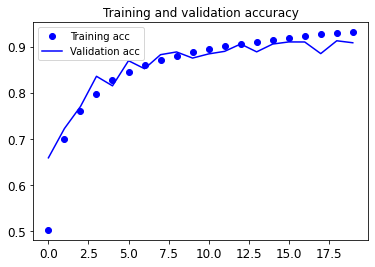

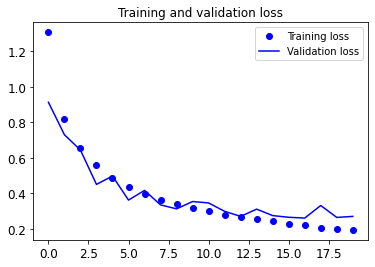

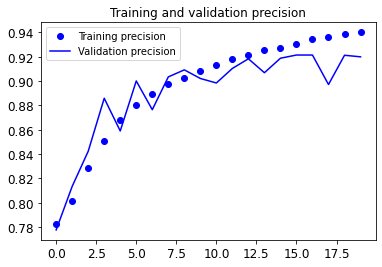

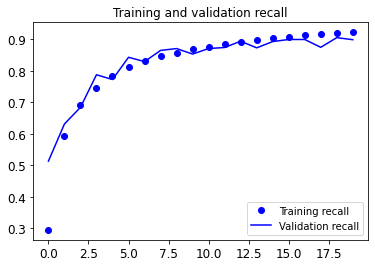

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, prec, 'bo', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.show()

In [ ]:
testdf = pd.read_csv('test/pathmnist.csv',dtype=str)
test_generator=datagen.flow_from_dataframe(
  dataframe=testdf,
  directory="test/pathmnist",
  x_col="test0_8.png",
  y_col="8",
  batch_size=1,
  seed=42,
  shuffle=False,
  class_mode="categorical",
  target_size=(64,64))

Found 7179 validated image filenames belonging to 9 classes.


In [ ]:
model.metrics_names

['loss', 'recall', 'precision', 'accuracy']

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
loss, recall, precision, accuracy = model.evaluate_generator(generator=test_generator,steps=STEP_SIZE_TEST)

<ipython-input-37-e53eca3b0ca2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, recall, precision, accuracy = model.evaluate_generator(generator=test_generator,steps=STEP_SIZE_TEST)


In [ ]:
print("Recall sul test set:")
print(recall)

print("Precision sul test set:")
print(precision)

print("Accuracy sul test set:")
print(accuracy)

Recall sul test set:
0.8406463265419006
Precision sul test set:
0.8690956234931946
Accuracy sul test set:
0.8529043197631836


In [ ]:
y_prediction = model.predict_generator(generator=test_generator)

<ipython-input-39-dadcffcc2294>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_prediction = model.predict_generator(generator=test_generator)


In [ ]:
y_test = testdf["8"]

In [ ]:
y_prediction = np.argmax (y_prediction, axis = 1)

In [ ]:
y_prediction.dtype

dtype('int64')

In [ ]:
y_test = y_test.astype("int64")

In [ ]:
from sklearn.metrics import confusion_matrix

result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)


[[9.37589670e-01 3.16122234e-03 1.93423598e-03 0.00000000e+00
  1.31147541e-02 2.83400810e-02 1.56250000e-03 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 8.92518440e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.33849130e-01 0.00000000e+00
  1.09289617e-03 2.22672065e-02 0.00000000e+00 1.30303030e-01
  6.09756098e-03]
 [7.17360115e-04 0.00000000e+00 3.86847195e-02 9.21974522e-01
  0.00000000e+00 0.00000000e+00 1.40625000e-02 3.03030303e-03
  1.82926829e-02]
 [5.88235294e-02 8.00842993e-02 9.67117988e-03 0.00000000e+00
  9.23497268e-01 2.02429150e-03 3.75000000e-02 0.00000000e+00
  1.52439024e-03]
 [7.17360115e-04 1.79135933e-02 9.67117988e-02 0.00000000e+00
  2.40437158e-02 7.95546559e-01 7.81250000e-03 2.45454545e-01
  1.75304878e-02]
 [2.15208034e-03 0.00000000e+00 7.15667311e-02 4.29936306e-02
  1.53005464e-02 1.01214575e-02 8.82812500e-01 9.09090909e-03
  6.63109756e-02]
 [0.00

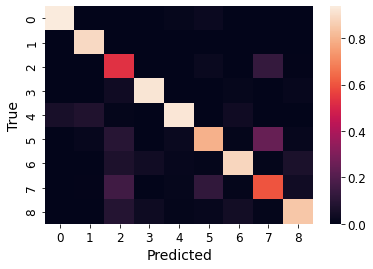

In [ ]:
import seaborn as sns

sns.heatmap(result)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Visualization

In [ ]:
from keras import models

# uso una list comprehension per creare una lista in modo semplice prendendo solamente l'output di 
# ogni livello della rete
layer_outputs = [layer.output for layer in model.layers[1:7]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# immagine di test classificata come tessuto tumorale
img_path = "./test/pathmnist/test0_8.png"

# recupero un'immagine di test
img = tf.keras.utils.load_img(img_path, target_size=(64, 64))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# normalization
img_tensor /= 255.

print(img_tensor.shape)

(1, 64, 64, 3)


In [ ]:
# immagine di test classificata come tessuto normale e sano
img_path1 = "./test/pathmnist/test1006_6.png"

# recupero un'immagine di test
img1 = tf.keras.utils.load_img(img_path1, target_size=(64, 64))
img_tensor1 = tf.keras.utils.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)

# normalization
img_tensor1 /= 255.

print(img_tensor1.shape)

(1, 64, 64, 3)


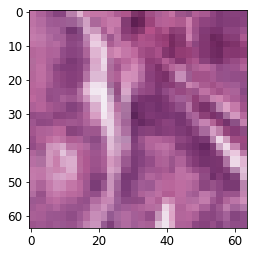

In [ ]:
# immagine di test scelta per il tessuto tumorale

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

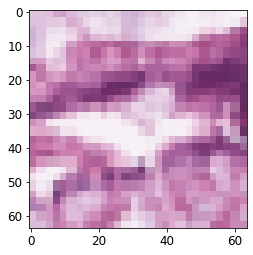

In [ ]:
# immagine di test scelta per il tessuto sano

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor1[0])
plt.show()

In [ ]:
# calcolo i diversi output del modello per il tessuto tumorale 
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 67ms/step


In [ ]:
# calcolo i diversi output del modello per il tessuto sano
activations1 = activation_model.predict(img_tensor1)

1/1 [==============================] - 0s 14ms/step


In [ ]:
# osserviamo l'output dopo il primo livello per il tessuto 
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 28, 28, 64)


### Analisi output tessuto tumorale

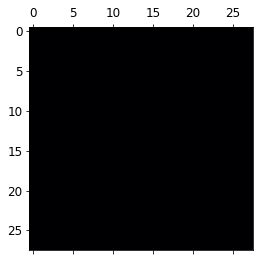

In [ ]:

plt.matshow(first_layer_activation[0, :, :, 3], cmap='inferno')
plt.show()

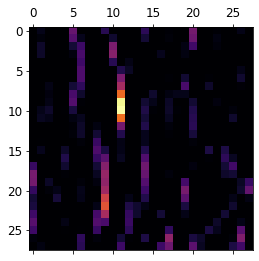

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 6], cmap='inferno')
plt.show()

<ipython-input-56-db7ac127f6b3>:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


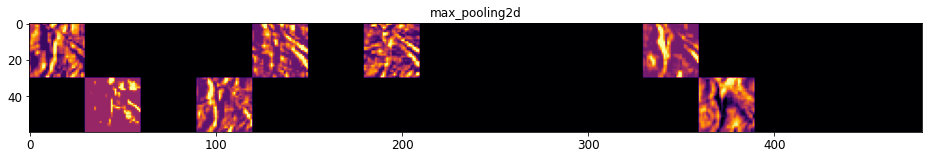

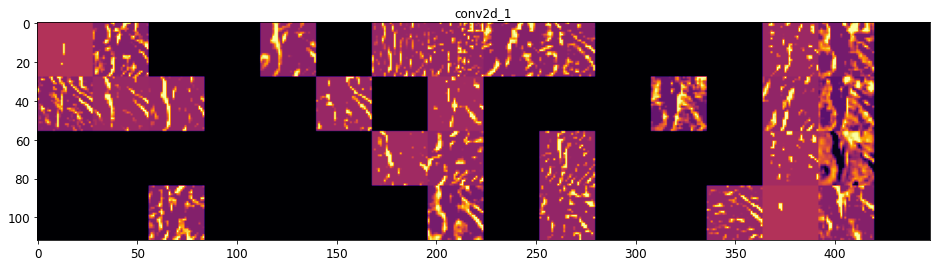

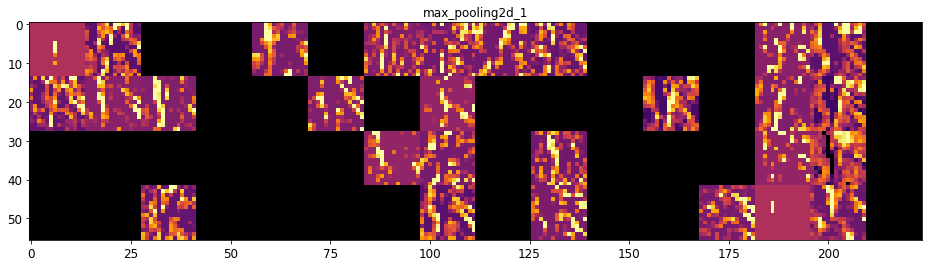

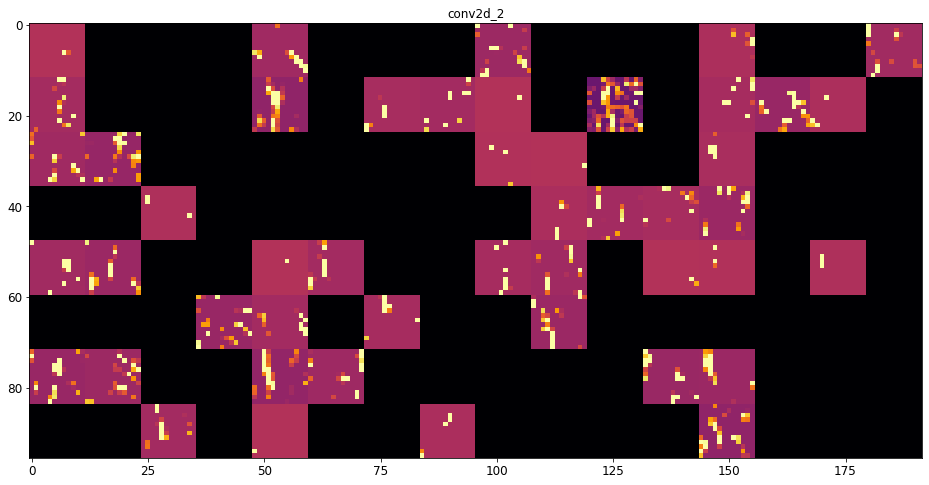

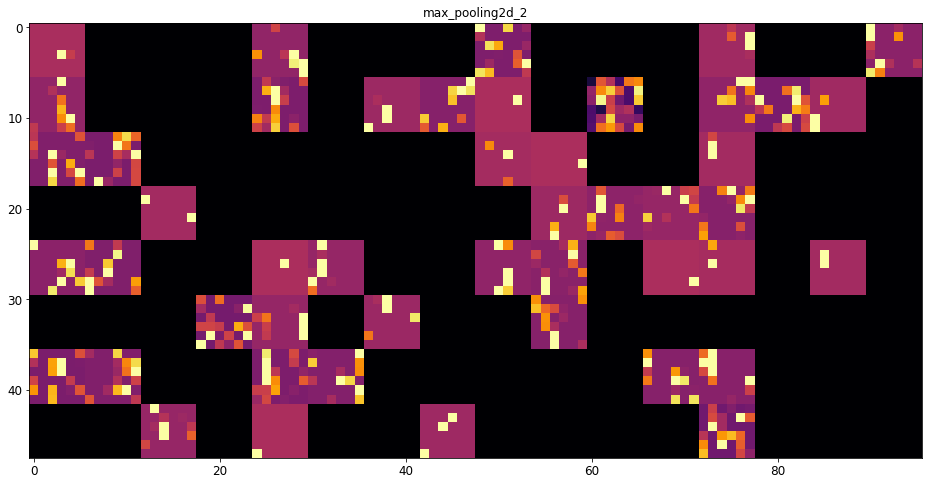

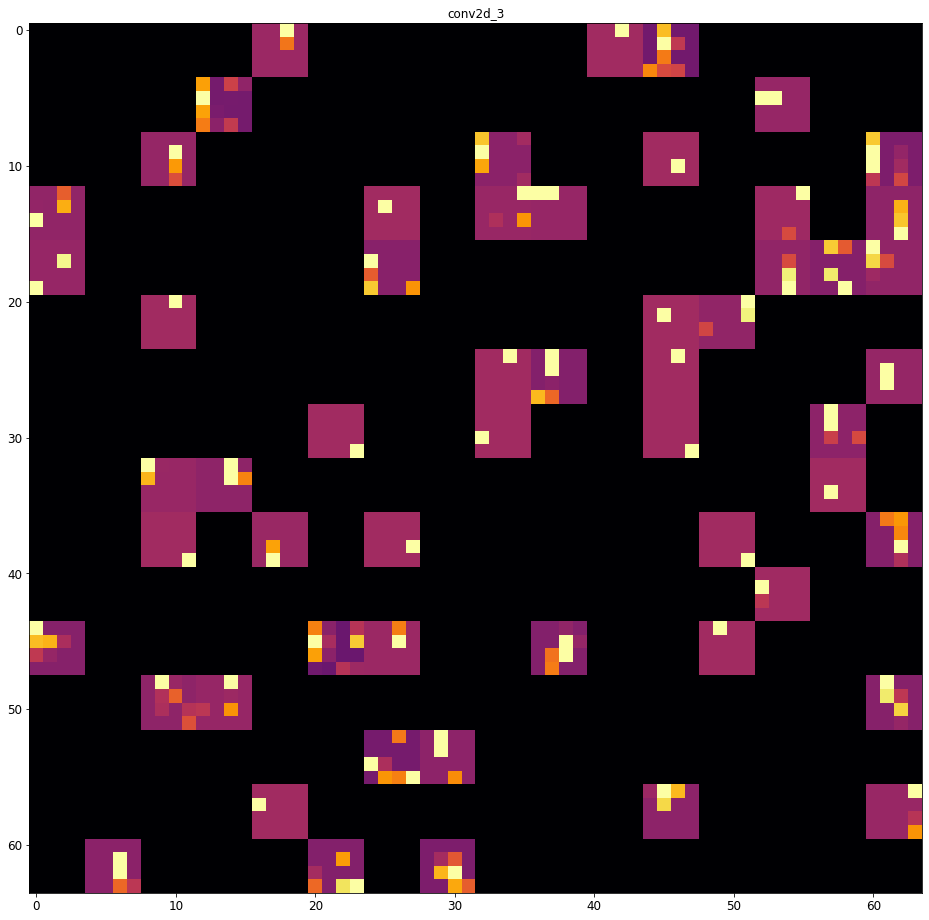

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(int(scale * display_grid.shape[1]),
                        int(scale * display_grid.shape[0])))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')
    
plt.show()

### Analisi output tessuto sano

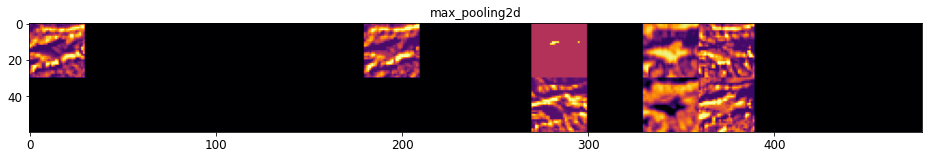

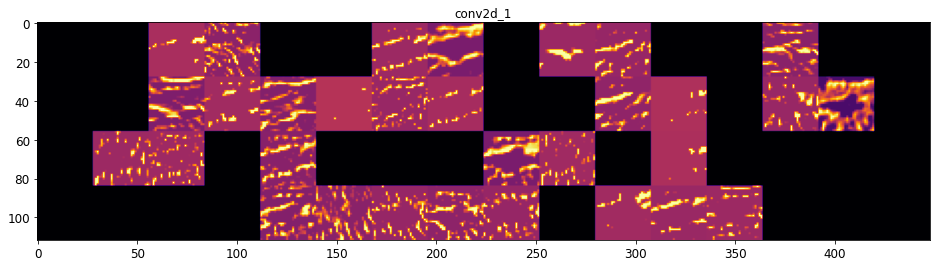

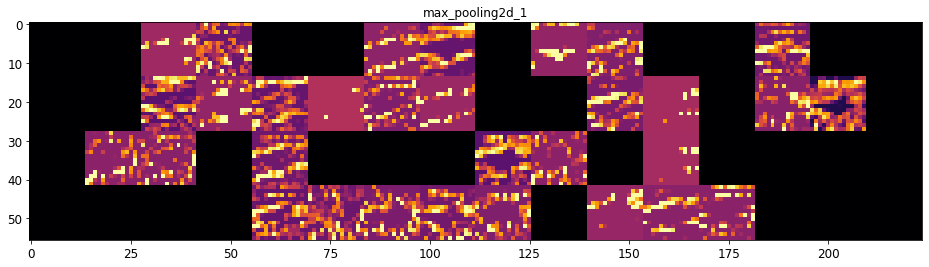

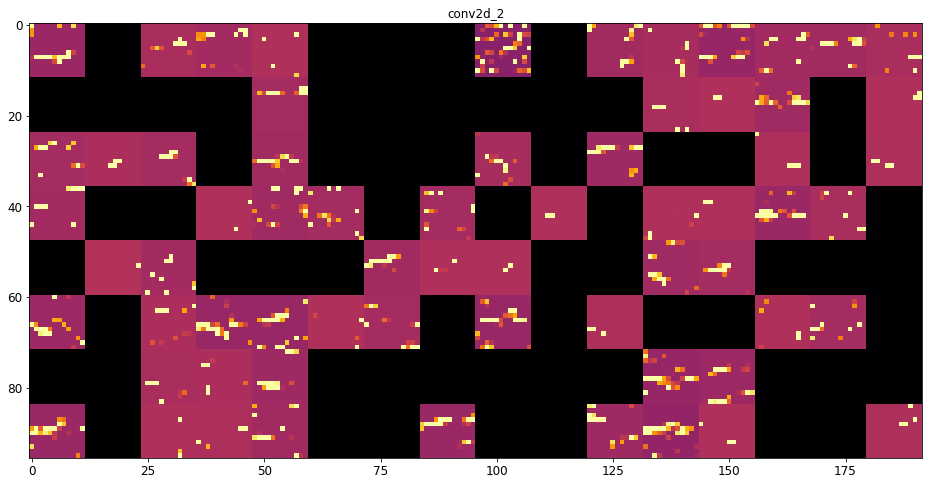

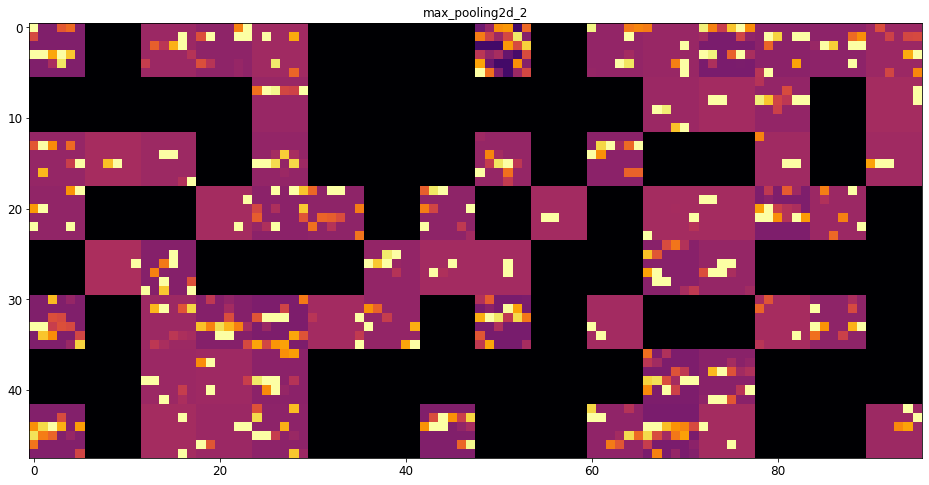

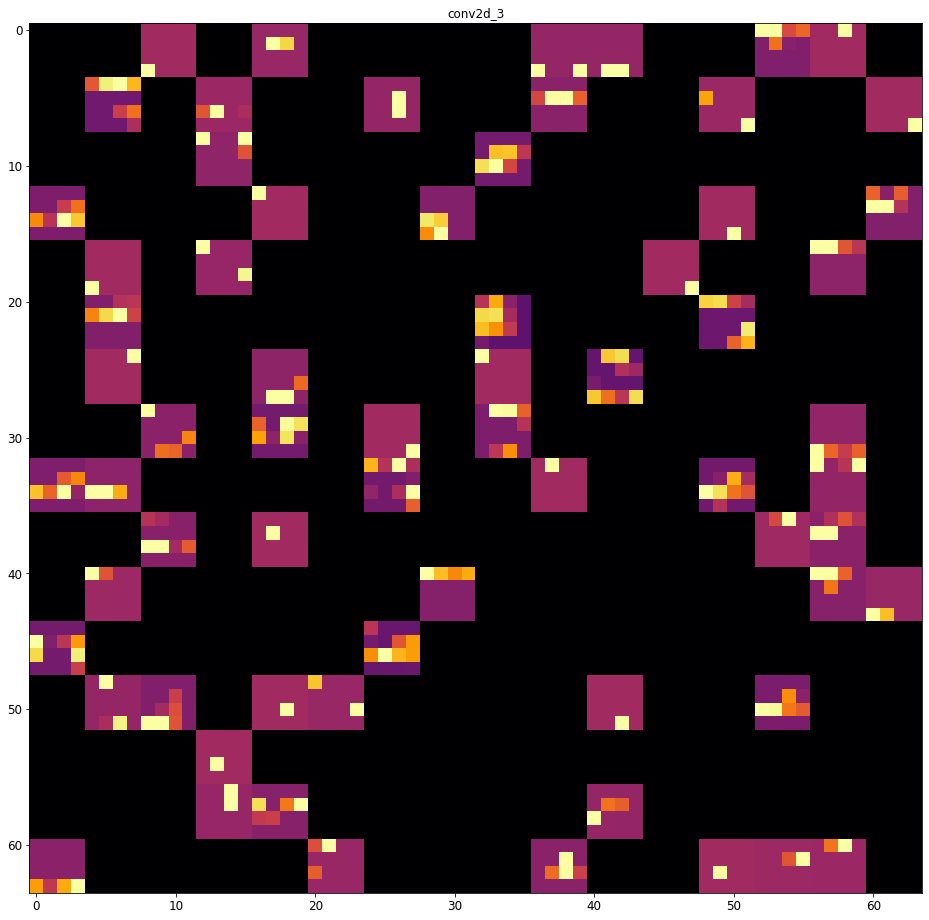

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations1):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(int(scale * display_grid.shape[1]),
                        int(scale * display_grid.shape[0])))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='inferno')
    
plt.show()

## VGG-16

Come secondo modello per questo progetto ho deciso di utilizzare la rete VGG-16 tramite la tecnica del **Transfer Learning**. 
Farò quindi un fine tuning della rete per speficarla sul task del progetto in questione.

Prima di tutto definisco dei nuovi generatori in modo da ottenere le immagini nella dimensione corretta per essere usate come input per VGG-16.

In [ ]:
traindf2=pd.read_csv('train/pathmnist.csv',dtype=str)
datagen2=ImageDataGenerator(rescale=1./255.)

train_generator2=datagen2.flow_from_dataframe(
  dataframe=traindf2,
  directory="train/pathmnist",
  x_col="train0_0.png",
  y_col="0",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(32,32))

Found 89995 validated image filenames belonging to 9 classes.


In [ ]:
valdf2 = pd.read_csv('validation/pathmnist.csv',dtype=str)
val_generator2=datagen2.flow_from_dataframe(
  dataframe=valdf2,
  directory="validation/pathmnist",
  x_col="val0_5.png",
  y_col="5",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(32,32))

Found 10003 validated image filenames belonging to 9 classes.


Importo la rete da Keras, specificando i pesi pre-addestrati sul dataset imageNet e specificando l'input desiderato, in modo che corrisponda con le mie immagini.

In [ ]:
from keras.applications import VGG16

rete_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
rete_base.summary(expand_nested=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from keras import models
from keras import layers

modelVGG = models.Sequential()
modelVGG.add(rete_base)
modelVGG.add(layers.Flatten())
modelVGG.add(layers.Dense(256, activation='relu'))
modelVGG.add(layers.Dense(512, activation='relu'))
modelVGG.add(layers.Dropout(0.2))
modelVGG.add(layers.Dense(9, activation='softmax'))

modelVGG.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 9)                 4617      
                                                                 
Total params: 14,982,217
Trainable params: 14,982,217


In [ ]:
print("Numero di livelli allenabili prima del freeze:",len(modelVGG.trainable_weights))

Numero di livelli allenabili prima del freeze: 32


In [ ]:
rete_base.trainable = False

In [ ]:
print("Numero di livelli allenabili dopo del freeze:",len(modelVGG.trainable_weights))

Numero di livelli allenabili dopo del freeze: 6


In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
modelVGG.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[recall,precision,'accuracy'])

In [ ]:
STEP_SIZE_TRAIN2=train_generator2.n//train_generator2.batch_size
STEP_SIZE_VALID2=val_generator2.n//val_generator2.batch_size
history2 = modelVGG.fit(train_generator2,steps_per_epoch=STEP_SIZE_TRAIN2,validation_data=val_generator2,
                    validation_steps=STEP_SIZE_VALID2,epochs=20)

Epoch 1/20
2812/2812 [==============================] - 59s 18ms/step - loss: 0.8332 - recall: 0.5873 - precision: 0.8026 - accuracy: 0.6936 - val_loss: 0.7364 - val_recall: 0.6335 - val_precision: 0.8185 - val_accuracy: 0.7264
Epoch 2/20
2812/2812 [==============================] - 50s 18ms/step - loss: 0.7201 - recall: 0.6519 - precision: 0.8177 - accuracy: 0.7358 - val_loss: 0.7329 - val_recall: 0.6697 - val_precision: 0.7979 - val_accuracy: 0.7305
Epoch 3/20
2812/2812 [==============================] - 51s 18ms/step - loss: 0.6832 - recall: 0.6714 - precision: 0.8263 - accuracy: 0.7484 - val_loss: 0.7173 - val_recall: 0.6494 - val_precision: 0.8193 - val_accuracy: 0.7334
Epoch 4/20
2812/2812 [==============================] - 49s 18ms/step - loss: 0.6583 - recall: 0.6847 - precision: 0.8303 - accuracy: 0.7576 - val_loss: 0.6599 - val_recall: 0.6770 - val_precision: 0.8403 - val_accuracy: 0.7573
Epoch 5/20
2812/2812 [==============================] - 49s 17ms/step - loss: 0.6359 - r

In [ ]:
rete_base.trainable = True

In [ ]:
modelVGG.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=[recall,precision,'accuracy'])

In [ ]:
history_fineTuning = modelVGG.fit(train_generator2,steps_per_epoch=STEP_SIZE_TRAIN2,validation_data=val_generator2,
                    validation_steps=STEP_SIZE_VALID2,epochs=10)

Epoch 1/10
2812/2812 [==============================] - 97s 34ms/step - loss: 0.5000 - recall: 0.7740 - precision: 0.8564 - accuracy: 0.8183 - val_loss: 0.4410 - val_recall: 0.8165 - val_precision: 0.8702 - val_accuracy: 0.8400
Epoch 2/10
2812/2812 [==============================] - 94s 34ms/step - loss: 0.3681 - recall: 0.8413 - precision: 0.8929 - accuracy: 0.8673 - val_loss: 0.3581 - val_recall: 0.8418 - val_precision: 0.8934 - val_accuracy: 0.8662
Epoch 3/10
2812/2812 [==============================] - 94s 33ms/step - loss: 0.3023 - recall: 0.8721 - precision: 0.9102 - accuracy: 0.8908 - val_loss: 0.3395 - val_recall: 0.8653 - val_precision: 0.8988 - val_accuracy: 0.8825
Epoch 4/10
2812/2812 [==============================] - 93s 33ms/step - loss: 0.2573 - recall: 0.8921 - precision: 0.9225 - accuracy: 0.9074 - val_loss: 0.2572 - val_recall: 0.8960 - val_precision: 0.9274 - val_accuracy: 0.9098
Epoch 5/10
2812/2812 [==============================] - 94s 33ms/step - loss: 0.2184 - r

In [ ]:
history_fineTuning.history

{'loss': [0.49996325373649597,
  0.3680797219276428,
  0.3022793233394623,
  0.2572513222694397,
  0.21838027238845825,
  0.19111324846744537,
  0.16802285611629486,
  0.1456199288368225,
  0.12827451527118683,
  0.1112578734755516],
 'recall': [0.7739601731300354,
  0.8413459062576294,
  0.8720918893814087,
  0.8921000957489014,
  0.9093182682991028,
  0.9215899705886841,
  0.9313828945159912,
  0.9409312605857849,
  0.9484121203422546,
  0.9549925923347473],
 'precision': [0.8564358353614807,
  0.8929393291473389,
  0.9101835489273071,
  0.92254638671875,
  0.9345084428787231,
  0.9421156048774719,
  0.9482582807540894,
  0.9550613760948181,
  0.9590189456939697,
  0.9640476703643799],
 'accuracy': [0.818291962146759,
  0.8672899007797241,
  0.8907884359359741,
  0.9073730111122131,
  0.9212787747383118,
  0.9314607381820679,
  0.9391860961914062,
  0.9476785063743591,
  0.953380823135376,
  0.959316611289978],
 'val_loss': [0.44104811549186707,
  0.3580596148967743,
  0.339526891708

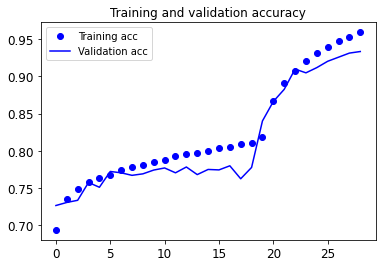

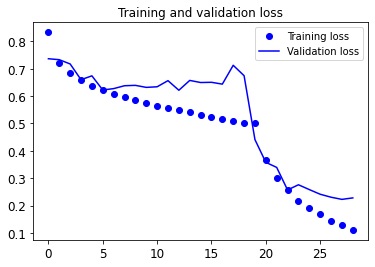

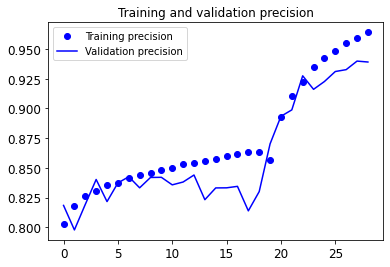

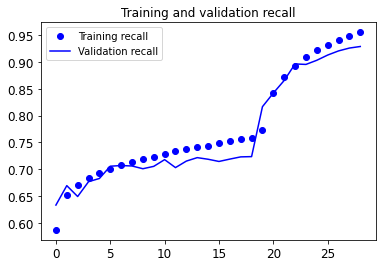

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc2 = history2.history['accuracy']
acc3 = acc2[0:19]
accFT = history_fineTuning.history['accuracy']
acc = np.concatenate((acc3,accFT))

val_acc2 = history2.history['val_accuracy']
val_acc3 = val_acc2[0:19]
val_accFT = history_fineTuning.history['val_accuracy']
val_acc = np.concatenate((val_acc3,val_accFT))

loss2 = history2.history['loss']
loss3 = loss2[0:19]
lossFT = history_fineTuning.history['loss']
loss = np.concatenate((loss3,lossFT))

val_loss2 = history2.history['val_loss']
val_loss3 = val_loss2[0:19]
val_lossFT = history_fineTuning.history['val_loss']
val_loss = np.concatenate((val_loss3,val_lossFT))

prec2 = history2.history['precision']
prec3 = prec2[0:19]
precFT = history_fineTuning.history['precision']
prec = np.concatenate((prec3,precFT))

val_prec2 = history2.history['val_precision']
val_prec3 = val_prec2[0:19]
val_precFT = history_fineTuning.history['val_precision']
val_prec = np.concatenate((val_prec3,val_precFT))

recall2 = history2.history['recall']
recall3 = recall2[0:19]
recallFT = history_fineTuning.history['recall']
recall = np.concatenate((recall3,recallFT))

val_recall2 = history2.history['val_recall']
val_recall3 = val_recall2[0:19]
val_recallFT = history_fineTuning.history['val_recall']
val_recall = np.concatenate((val_recall3,val_recallFT))

epochs = range(29)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, prec, 'bo', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.show()

Possiamo vedere come la rete, durante il training, abbia mostrato un pochino di overfitting nelle epoche finali del primo addestramento.
Nel corso del fine tuning invece si è comportata molto bene, portando a ottimi risultati in tutte e 3 le metriche analizzate.

In [ ]:
testdf2 = pd.read_csv('test/pathmnist.csv',dtype=str)
test_generator2=datagen2.flow_from_dataframe(
  dataframe=testdf2,
  directory="test/pathmnist",
  x_col="test0_8.png",
  y_col="8",
  batch_size=1,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(32,32))

Found 7179 validated image filenames belonging to 9 classes.


In [ ]:
STEP_SIZE_TEST2=test_generator2.n//test_generator2.batch_size
loss, recall, precision, accuracy = modelVGG.evaluate_generator(generator=test_generator2,steps=STEP_SIZE_TEST2)

<ipython-input-97-e80411f620d2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, recall, precision, accuracy = modelVGG.evaluate_generator(generator=test_generator2,steps=STEP_SIZE_TEST2)


In [ ]:
print("Recall sul test set:")
print(recall)

print("Precision sul test set:")
print(precision)

print("Accuracy sul test set:")
print(accuracy)

Recall sul test set:
0.8562473654747009
Precision sul test set:
0.8704333305358887
Accuracy sul test set:
0.8615406155586243


## Xception

In [ ]:
from keras.applications import Xception

rete_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(299, 299, 3))

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
rete_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
from keras import models
from keras import layers

modelX = models.Sequential()
modelX.add(rete_base)
modelX.add(layers.Flatten())
modelX.add(layers.Dense(256, activation='relu'))
modelX.add(layers.Dropout(0.4))
modelX.add(layers.Dense(9, activation='softmax'))

modelX.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               52429056  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 73,292,849
Trainable params: 52,431,369
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
print("Numero di livelli allenabili prima del freeze:",len(modelX.trainable_weights))
print("Freeze del modello..")
rete_base.trainable = False
print("Numero di livelli allenabili dopo del freeze:",len(modelX.trainable_weights))

Numero di livelli allenabili prima del freeze: 158
Freeze del modello..
Numero di livelli allenabili dopo del freeze: 4


In [ ]:
traindf3=pd.read_csv('train/pathmnist.csv',dtype=str)
datagen3=ImageDataGenerator(rescale=1./255.)

train_generator3=datagen3.flow_from_dataframe(
  dataframe=traindf3,
  directory="train/pathmnist",
  x_col="train0_0.png",
  y_col="0",
  subset="training",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(299,299))

Found 89995 validated image filenames belonging to 9 classes.


In [ ]:
valdf3 = pd.read_csv('validation/pathmnist.csv',dtype=str)
val_generator3=datagen3.flow_from_dataframe(
  dataframe=valdf3,
  directory="validation/pathmnist",
  x_col="val0_5.png",
  y_col="5",
  batch_size=32,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(299,299))

Found 10003 validated image filenames belonging to 9 classes.


In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [ ]:
modelX.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[recall,precision,'accuracy'])

In [ ]:
STEP_SIZE_TRAIN3=train_generator3.n//train_generator3.batch_size
STEP_SIZE_VALID3=val_generator3.n//val_generator3.batch_size
history3 = modelX.fit(train_generator3,steps_per_epoch=STEP_SIZE_TRAIN3,validation_data=val_generator3,
                    validation_steps=STEP_SIZE_VALID3,epochs=8)

Epoch 1/8
2812/2812 [==============================] - 910s 322ms/step - loss: 0.8550 - recall: 0.6346 - precision: 0.8226 - accuracy: 0.7322 - val_loss: 0.4240 - val_recall: 0.8030 - val_precision: 0.9138 - val_accuracy: 0.8599
Epoch 2/8
2812/2812 [==============================] - 903s 321ms/step - loss: 0.5780 - recall: 0.7449 - precision: 0.8691 - accuracy: 0.8023 - val_loss: 0.4160 - val_recall: 0.8434 - val_precision: 0.8994 - val_accuracy: 0.8680
Epoch 3/8
2812/2812 [==============================] - 903s 321ms/step - loss: 0.5194 - recall: 0.7743 - precision: 0.8839 - accuracy: 0.8236 - val_loss: 0.3843 - val_recall: 0.8508 - val_precision: 0.9099 - val_accuracy: 0.8775
Epoch 4/8
2812/2812 [==============================] - 904s 322ms/step - loss: 0.4711 - recall: 0.7935 - precision: 0.8912 - accuracy: 0.8373 - val_loss: 0.4026 - val_recall: 0.8304 - val_precision: 0.9221 - val_accuracy: 0.8762
Epoch 5/8
2812/2812 [==============================] - 905s 322ms/step - loss: 0.440

In [ ]:
history3.history

{'loss': [0.854985773563385,
  0.5780115723609924,
  0.519375741481781,
  0.47105059027671814,
  0.4408641457557678,
  0.4109507203102112,
  0.3903801143169403,
  0.37421882152557373],
 'recall': [0.6346310377120972,
  0.7448728680610657,
  0.7742627263069153,
  0.7934595346450806,
  0.8081099987030029,
  0.8215711116790771,
  0.8300968408584595,
  0.8375998735427856],
 'precision': [0.822599470615387,
  0.8691439628601074,
  0.883901834487915,
  0.8911610245704651,
  0.8969992995262146,
  0.9044198393821716,
  0.9068586826324463,
  0.9103902578353882],
 'accuracy': [0.7321898937225342,
  0.8022520542144775,
  0.8236386179924011,
  0.837344229221344,
  0.8472594022750854,
  0.8581416606903076,
  0.8640552163124084,
  0.8686348795890808],
 'val_loss': [0.42397791147232056,
  0.416025847196579,
  0.38432180881500244,
  0.40258273482322693,
  0.380388468503952,
  0.3814161717891693,
  0.3898896276950836,
  0.3637901842594147],
 'val_recall': [0.8029847741127014,
  0.8434495329856873,
  0.

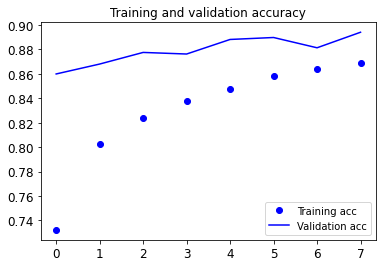

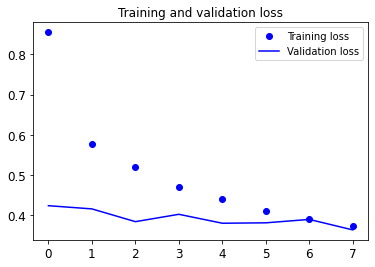

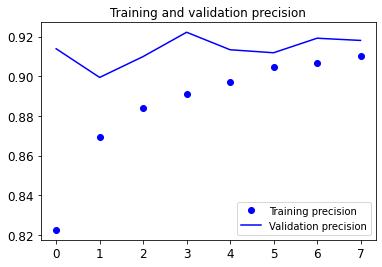

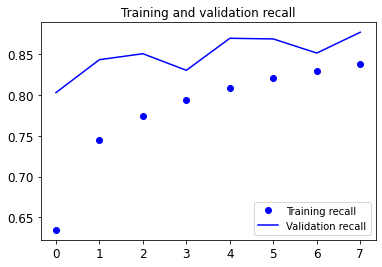

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

prec = history3.history['precision']
val_prec = history3.history['val_precision']

recall = history3.history['recall']
val_recall = history3.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, prec, 'bo', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.show()

In [ ]:
testdf3 = pd.read_csv('test/pathmnist.csv',dtype=str)
test_generator3=datagen3.flow_from_dataframe(
  dataframe=testdf3,
  directory="test/pathmnist",
  x_col="test0_8.png",
  y_col="8",
  batch_size=1,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(299,299))

Found 7179 validated image filenames belonging to 9 classes.


In [ ]:
STEP_SIZE_TEST3=test_generator3.n//test_generator3.batch_size
loss, recall, precision, accuracy = modelX.evaluate_generator(generator=test_generator3,steps=STEP_SIZE_TEST3)

<ipython-input-45-3b31732e2d3a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, recall, precision, accuracy = modelX.evaluate_generator(generator=test_generator3,steps=STEP_SIZE_TEST3)


In [ ]:
print("Recall sul test set:")
print(recall)

print("Precision sul test set:")
print(precision)

print("Accuracy sul test set:")
print(accuracy)

Recall sul test set:
0.8771033883094788
Precision sul test set:
0.9180207848548889
Accuracy sul test set:
0.8940304517745972
